<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human driving - [GAIL](https://arxiv.org/abs/1606.03476)

# Library

In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn

from Utils.Environment_LC import ENVIRONMENT
from Utils.PPO import PPO
from Utils.GAIL import DISCRIMINATOR_FUNCTION   # NEW compare to PPO code

Path = os.getcwd()
print(Path)
PATH = "Trained_model/GAIL_0.pth"

#CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

/home/hice1/yzhu734/GAIL-example/GAIL-example
cpu


In [12]:
# NEW compare to PPO code
# Training
try:
    expert_traj = np.load("Expert_trajectory/expert_traj.npy", allow_pickle=True)
except:
    print("Train, generate and save expert trajectories")
    assert False

# Testing
try:
    testing_traj = np.load("Expert_trajectory/testing_traj.npy", allow_pickle=True)
except:
    print("Train, generate and save expert trajectories")
    assert False

# Hyperparameters

In [13]:
EIDM_do = True
A_para = 'normal'
B_para = '2000'
Env = ENVIRONMENT(
    para_B                          = B_para,                               
    para_A                          = A_para, 
    noise                           = True)

In [14]:
K_epochs = 16              # update policy for K epochs
eps_clip = 0.15             # clip parameter for PPO
gamma = 0.95                # discount factor

lr_actor = 0.001#0.001            # learning rate for actor network
lr_critic = 0.001#0.001           # learning rate for critic network

has_continuous_action_space = True

update_episode = 2

total_episodes   =  1200
# action_std_decay_freq = 10
# action_std_decay_rate = 0.01
# min_action_std = 0.01  
save_model_freq = 1


state_dim = 11
action_dim = 2 
action_bound = 2

ppo_agent  = PPO(state_dim, action_dim, action_bound, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.4)


# Print model's state_dict
print("Model's state_dict:")
for param_tensor in ppo_agent.policy.state_dict():
    print(param_tensor, "\t", ppo_agent.policy.state_dict()[param_tensor].size())

Model's state_dict:
actor_acc.0.weight 	 torch.Size([64, 11])
actor_acc.0.bias 	 torch.Size([64])
actor_acc.2.weight 	 torch.Size([64, 64])
actor_acc.2.bias 	 torch.Size([64])
actor_acc.4.weight 	 torch.Size([1, 64])
actor_acc.4.bias 	 torch.Size([1])
actor_yaw.0.weight 	 torch.Size([64, 11])
actor_yaw.0.bias 	 torch.Size([64])
actor_yaw.2.weight 	 torch.Size([64, 64])
actor_yaw.2.bias 	 torch.Size([64])
actor_yaw.4.weight 	 torch.Size([1, 64])
actor_yaw.4.bias 	 torch.Size([1])
critic.0.weight 	 torch.Size([64, 11])
critic.0.bias 	 torch.Size([64])
critic.2.weight 	 torch.Size([64, 64])
critic.2.bias 	 torch.Size([64])
critic.4.weight 	 torch.Size([1, 64])
critic.4.bias 	 torch.Size([1])


In [15]:
# NEW compare to PPO code
# Discriminator
D_epochs    = 8     # update discriminator for D epochs

lr_gail = 0.0005

expert_sample_size = expert_traj.shape[0] #len(expert_traj) 

Discriminator = DISCRIMINATOR_FUNCTION(state_dim, action_dim, lr_gail, D_epochs, expert_traj, expert_sample_size)

# Training

In [16]:
LC_end_pos = 0.5      # lateral position deviation
LC_end_yaw = 0.005    # yaw angle deviation 
PARAS = ['aggressive', 'normal', 'cautious']

path_idx    = 0
Time_len = 500
lane_wid = 3.75               
veh_len  = 5.0
v_0      = 30   

#for episode in tqdm(range(total_episodes)):
for episode in range(total_episodes):
    
    # Collect PPO outputs
    states      = [] # NEW compare to PPO code
    actions     = [] # NEW compare to PPO code
    
    for iter in range(3):
        A_para = PARAS[iter]   # interact with different driver types iteratively, aggressive, normal, and cautious
    
        # Environment    
        Env.reset()   
        LC_start = False   
        LC_starttime = 0
        LC_endtime   = 0
        LC_mid       = 0

        for t in range(1, Time_len):  
            s_t, env_t = Env.observe()       #Observation        
            if t != env_t + 1:               # check time consistency between Env and simulation codee
                print('warning: time inconsistency!')

            Dat = Env.read()                 # Read ground-truth information

            #Lane change indication
            if Dat[t-1,24]!=0 and LC_start == False and LC_starttime == 0:                 # if LC is true at the end of last time step
                LC_start = True  
                LC_starttime = t
            # finish lane change - stop in the center of the target lane
            elif abs(Dat[t-1,25] - 0.5*lane_wid) <= LC_end_pos and abs(Dat[t-1,26]) <= LC_end_yaw and LC_start == True and LC_endtime == 0:       
                LC_start = False
                LC_endtime   = t
            # out of boundary
            elif (Dat[t-1,25] <= - lane_wid or Dat[t-1,25] > 2.0 * lane_wid) and LC_start == True and LC_endtime == 0:       
                LC_start = False
                LC_endtime   = t
            
            # B cross the line    
            if Dat[t-1,25]<=lane_wid and LC_mid==0:
                LC_mid = t         # record the time cross lane-marking

            # Low-level task: action              
            if LC_start == False:
                # longitudinal
                if Dat[t-1,25] > lane_wid:    # B in lane 2, B follwo F
                    act_0 = Env.IDM_B(Dat[t-1,13], Dat[t-1,13] - Dat[t-1,10], Dat[t-1,9] - Dat[t-1,12] - veh_len) #IDM
                elif Dat[t-1,25] <= lane_wid:   # B cross the line, B follow E
                    act_0 = Env.IDM_B(Dat[t-1,13], Dat[t-1,13] - Dat[t-1,1], Dat[t-1,0] - Dat[t-1,12] - veh_len) #IDM
                
                # lateral
                act_1 = 0                   # yaw rate
                
                action = [act_0, act_1]
                Env.run(action)
            
            else:
                state, _ = Env.observe()

                action = ppo_agent.select_action(state)
                Env.run(action) # run human behavior
                state_next, _ = Env.observe()

                reward = Discriminator.reward(state, action)    # reward from the discriminator    # NEW compare to PPO code        
                
                if t == Time_len - 1:
                    done = True
                else:
                    done = False
                    
                ppo_agent.buffer.rewards.append(reward)
                ppo_agent.buffer.is_terminals.append(done)


                # Collect PPO outputs
                states.append(state) # NEW compare to PPO code
                actions.append(action) # NEW compare to PPO code

        
    # Policy
    if episode % update_episode  == 0:
        # PPO
        ppo_agent.update()

        # Discriminator
        states    = torch.FloatTensor(np.array(states)).squeeze().to(device) # NEW compare to PPO code
        actions   = torch.FloatTensor(np.array(actions)).to(device) # NEW compare to PPO code
        Discriminator.update(ppo_agent, states, actions) # NEW compare to PPO code

    ############# Record episode results ##########
    # write conditions you want to save the trained model during the training
    # Code
    
    if episode % save_model_freq  == 0:
        path_idx   += 1
        max_score = -np.inf
        PATH       = "Trained_model/GAIL_"+str(path_idx)+".pth"
        ppo_agent.save(PATH)


# Testing

In [17]:
loss = nn.MSELoss()
testing_trajectory = testing_traj[0]
for i in range(1,len(testing_traj)):
    testing_trajectory = np.concatenate((testing_trajectory, testing_traj[i]), axis=0)

testing_trajectory = testing_trajectory.reshape(-1,state_dim+action_dim+state_dim)
testing_trajectory = torch.FloatTensor(testing_trajectory).to(device)
testing_states, testing_actions, testing_states_next = torch.split(testing_trajectory, (state_dim,action_dim,state_dim), dim=1)

expert_trajectory = expert_traj[0]
for i in range(1,len(expert_traj)):
    expert_trajectory = np.concatenate((expert_trajectory, expert_traj[i]), axis=0)

expert_trajectory = expert_trajectory.reshape(-1,state_dim+action_dim+state_dim)
expert_trajectory = torch.FloatTensor(expert_trajectory).to(device)
expert_states, expert_actions, expert_states_next = torch.split(expert_trajectory, (state_dim,action_dim,state_dim), dim=1)

## MSE evaluation

In [18]:
MSE_test = []
idx = []
for item in range(0,total_episodes):
    PATH  = "Trained_model/GAIL_"+str(item)+".pth"
    
    if os.path.exists(PATH) == False:
        continue

    ppo_agent.load(PATH) 
    ppo_agent.set_action_std(0.00000000001) 
    ppo_agent.policy_old.eval()
    #print('PATH:', PATH)

    actions,_,_ = ppo_agent.policy_old.act(testing_states)
    
    mse = loss(actions, testing_actions).item()
    MSE_test.append(mse)
    idx.append(item)

print(np.argmin(MSE_test), MSE_test[np.argmin(MSE_test)], "Trained_model/GAIL_"+str(idx[np.argmin(MSE_test)])+".pth" )

472 0.05902663990855217 Trained_model/GAIL_473.pth


## Trajectory comparison

In [19]:
def Test_plot(actions, testing_actions):
    plt.figure(dpi=60, figsize=[36, 4]) 

    plt.subplot(1, 2, 1)
    plt.plot(actions[:,0],c='b', linewidth=1, label = 'AIRL')
    plt.plot(testing_actions[:,0],c='r', linewidth=1, label = 'Human')
    plt.gca().set_title('Acceleration')
    plt.xlabel('Time (0.1s)')
    plt.ylabel('Acc (m/s^2)')
    plt.legend()



    plt.subplot(1, 2, 2)
    plt.plot(actions[:,1],c='b', linewidth=1, label = 'AIRL')
    plt.plot(testing_actions[:,1],c='r', linewidth=1, label = 'Human')
    # plt.axhline(y=-0.2, c='m', linestyle='--', linewidth=1, label = 'lb')
    # plt.axhline(y=0.2, c='m', linestyle='--', linewidth=1, label ='ub')
    plt.gca().set_title('Yaw rate')
    plt.xlabel('Time (0.1s)')
    plt.ylabel('Yaw rate (rad/s)')
    plt.legend()

    plt.show()

0.3692817986011505


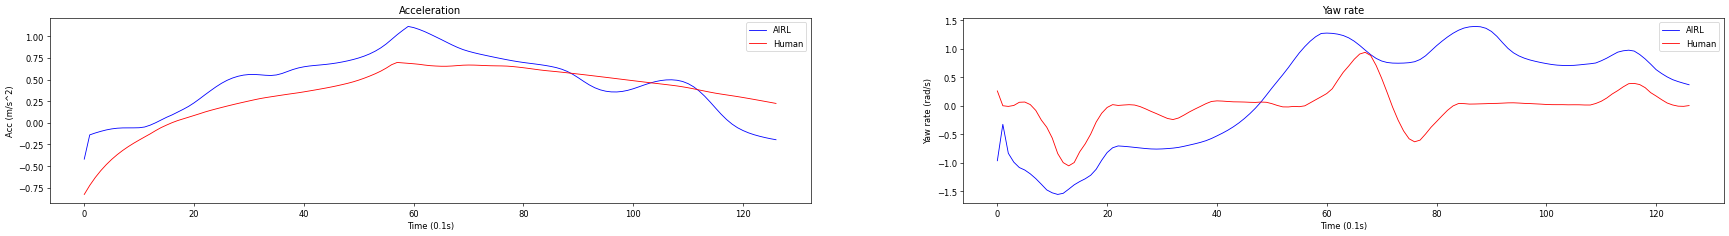

0.11189454793930054


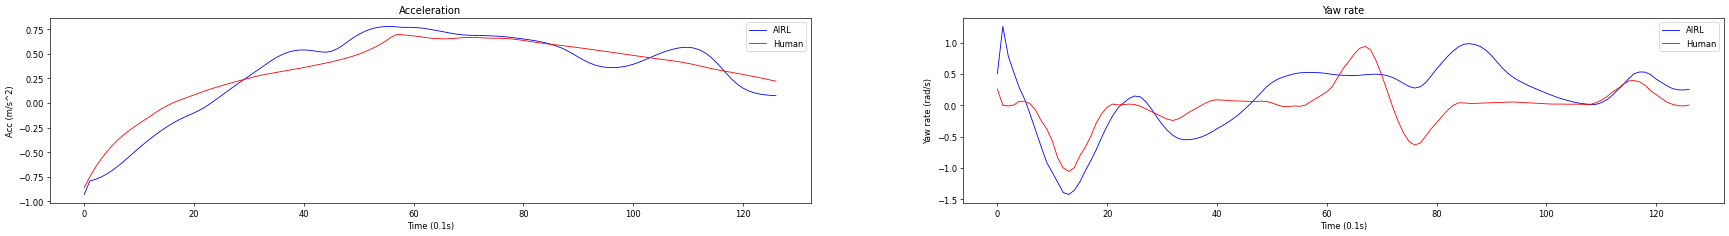

0.1452471762895584


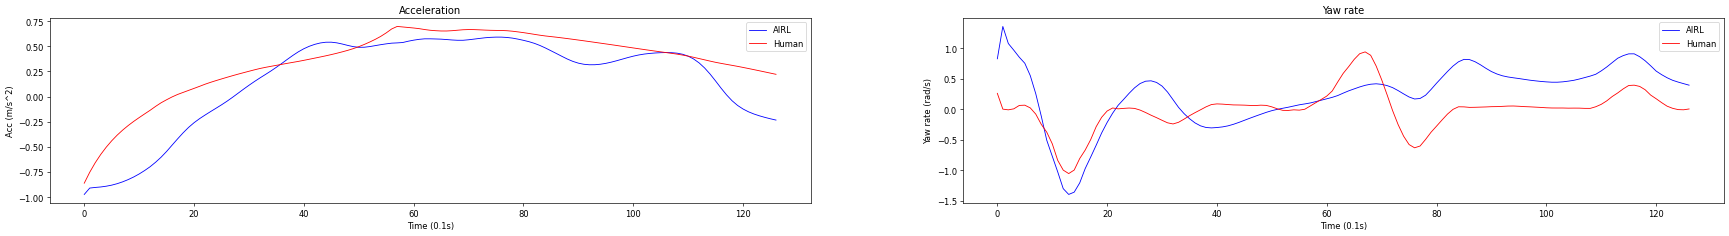

0.24984332919120789


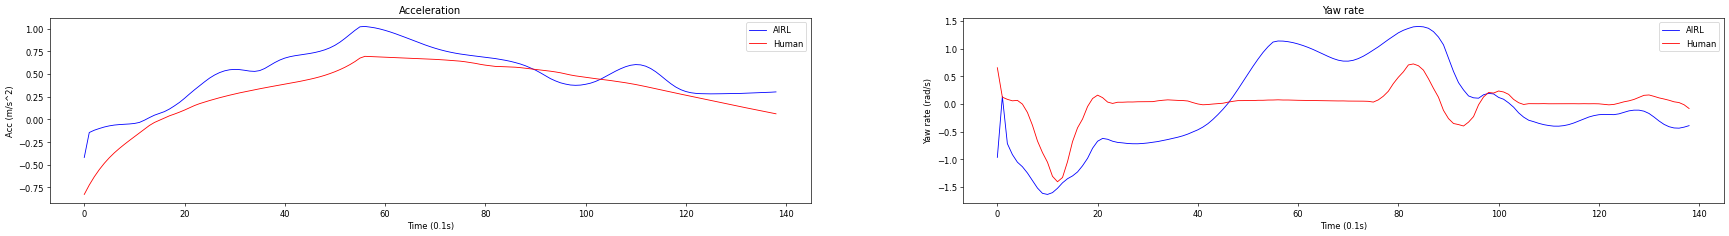

0.0800364539027214


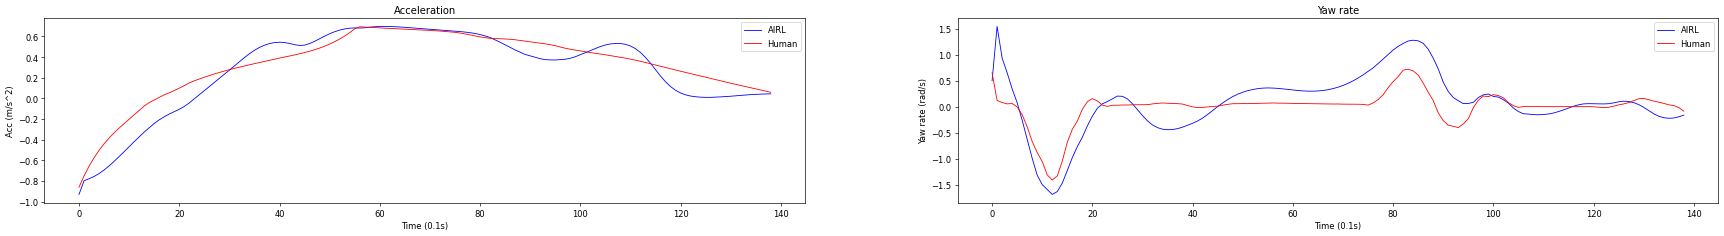

0.12839776277542114


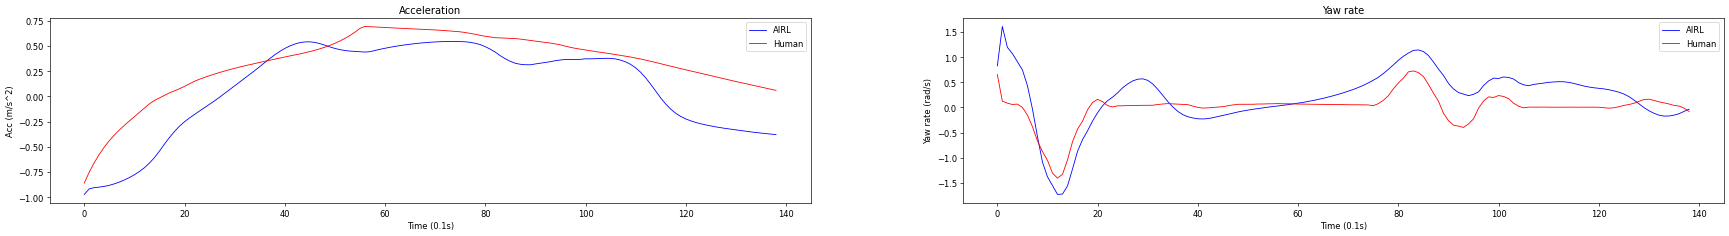

0.19547590613365173


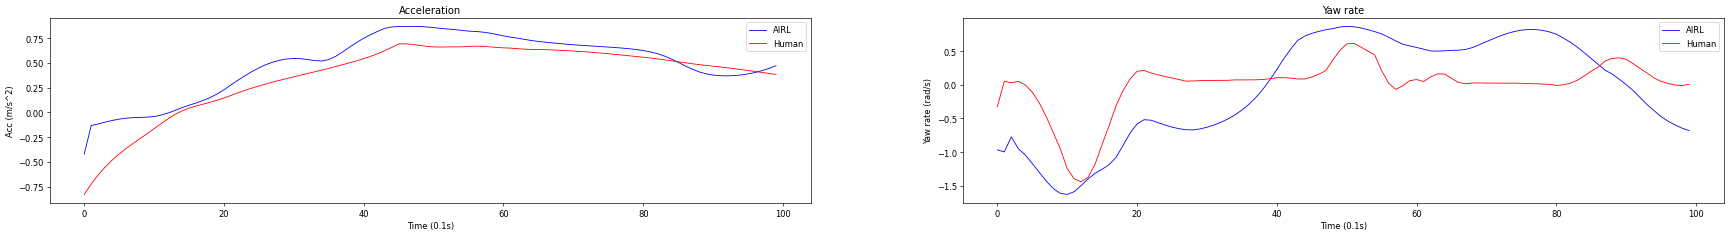

0.06100088730454445


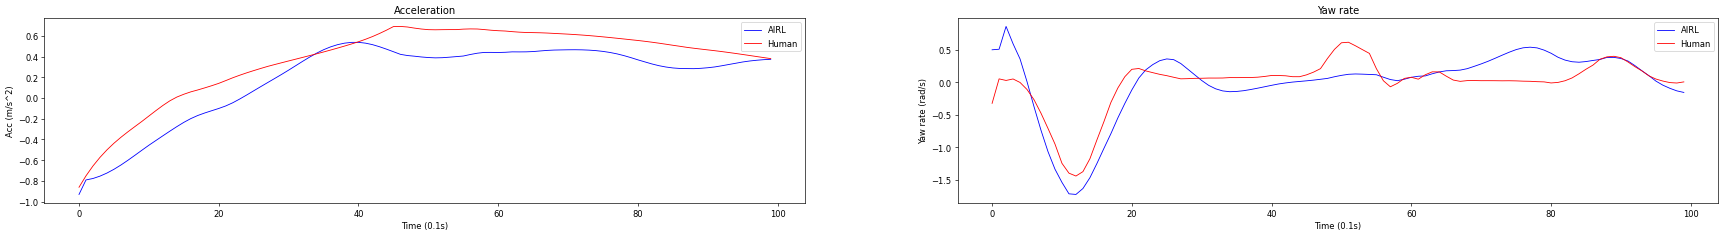

0.13563494384288788


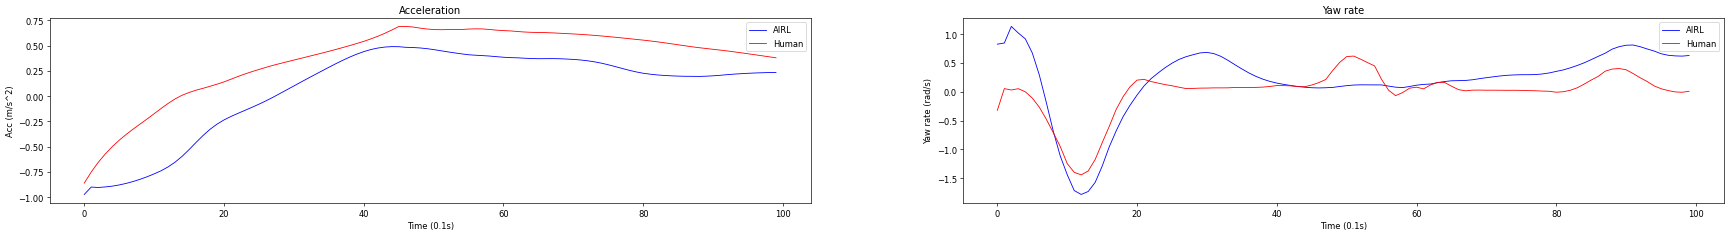

0.18788325786590576


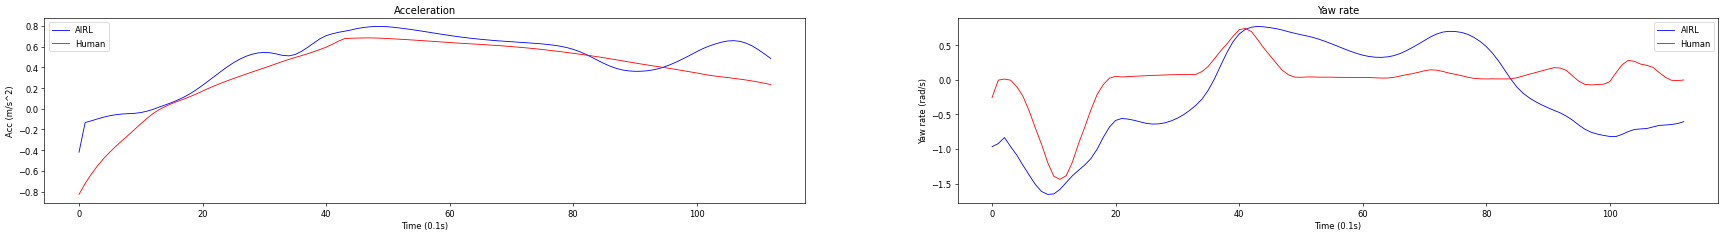

0.06012525036931038


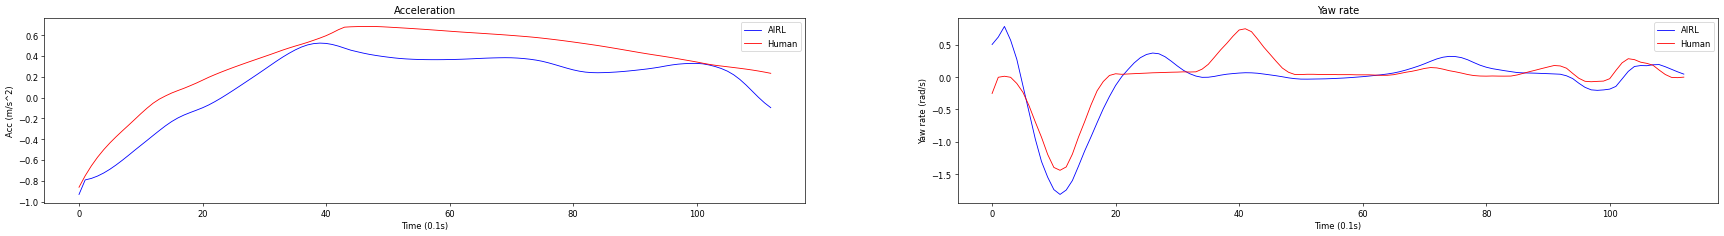

0.15794067084789276


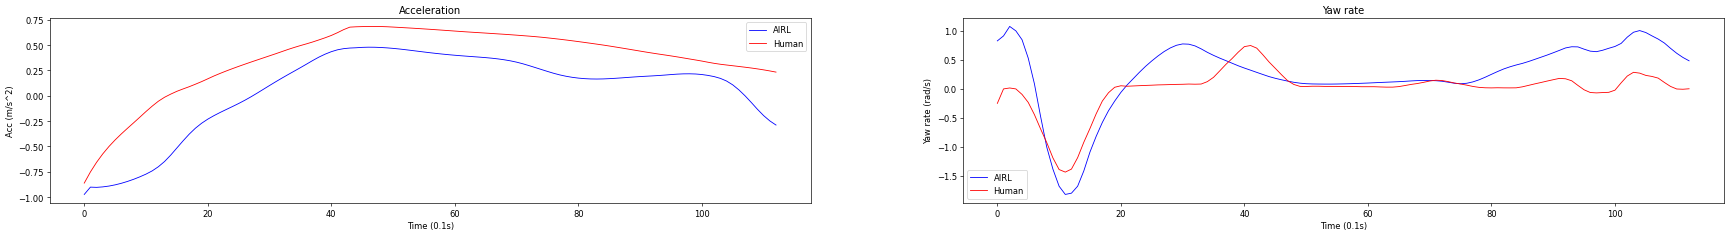

0.2321382462978363


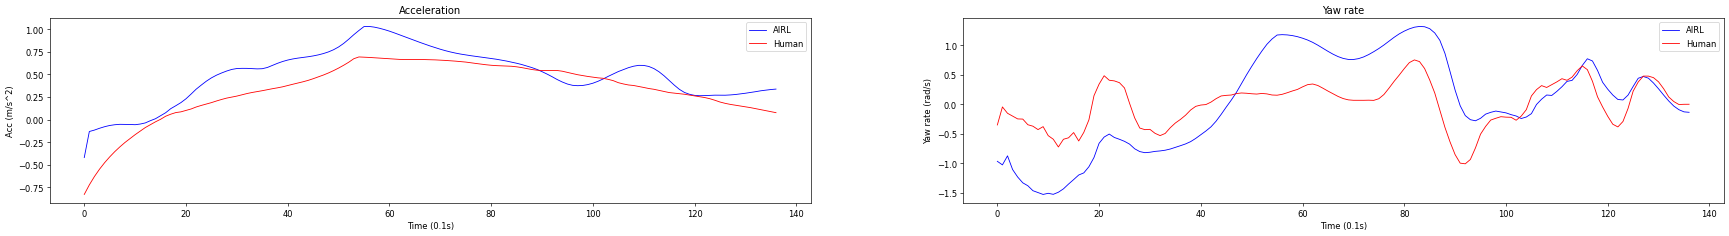

0.07863282412290573


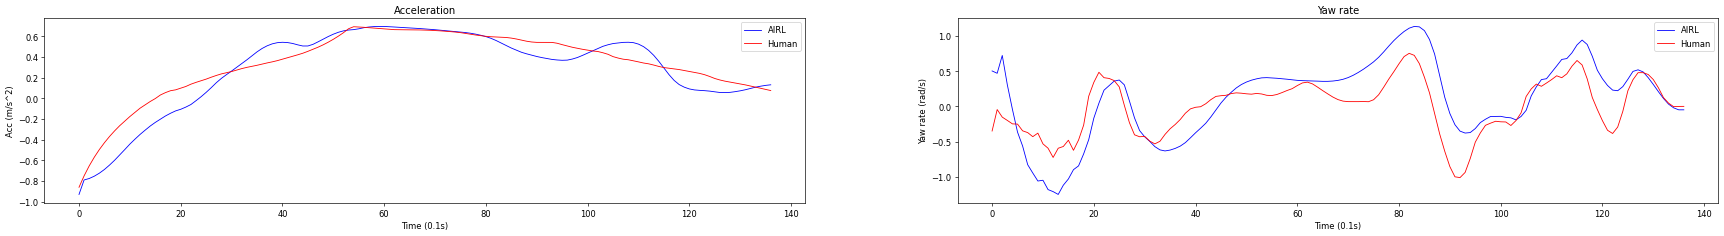

0.14436276257038116


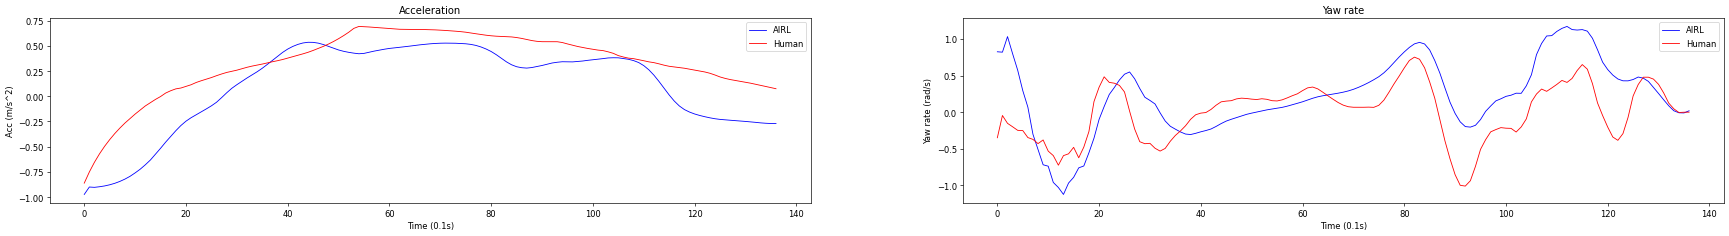

0.2853001058101654


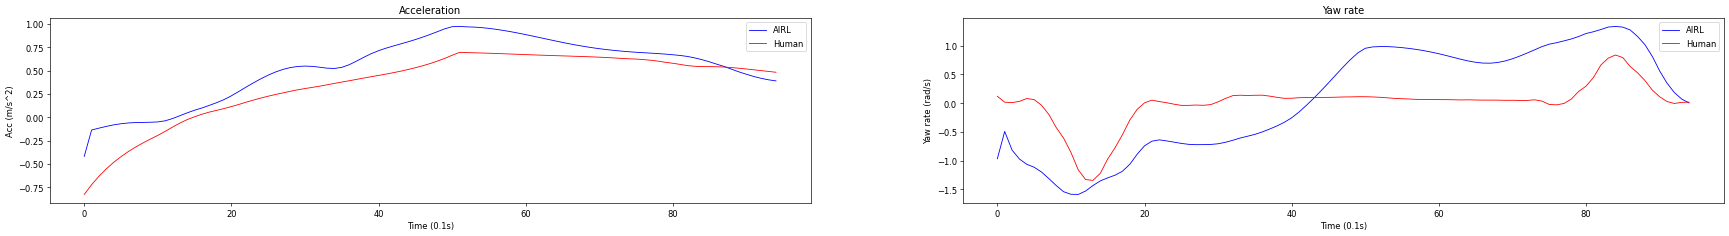

0.08573693782091141


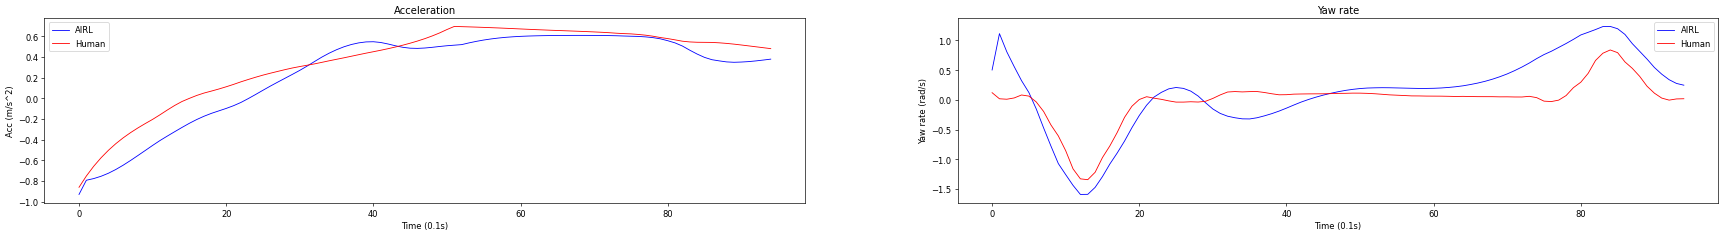

0.12594790756702423


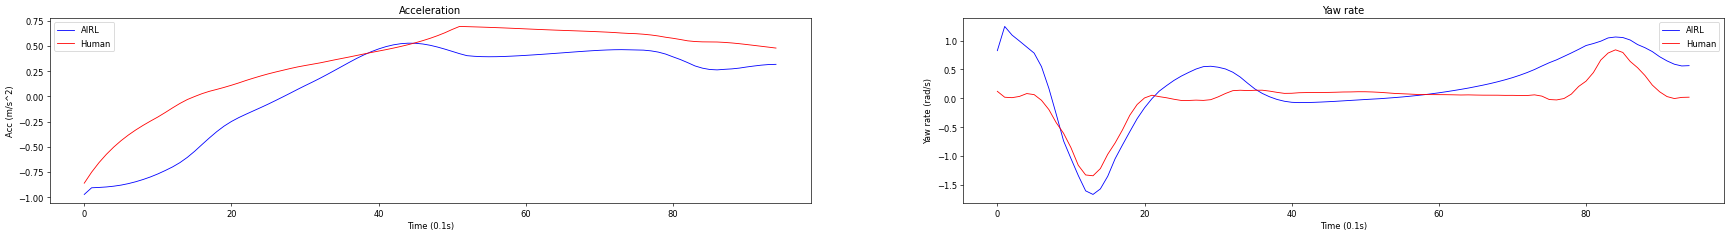

0.23813025653362274


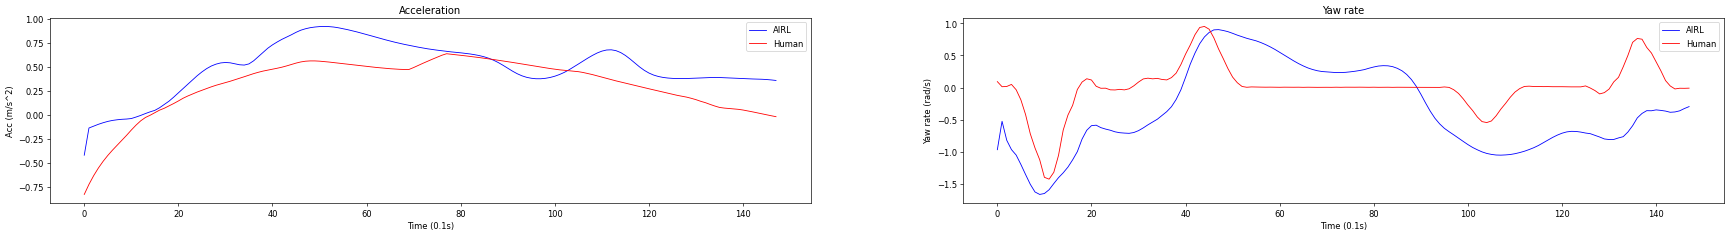

0.1112116128206253


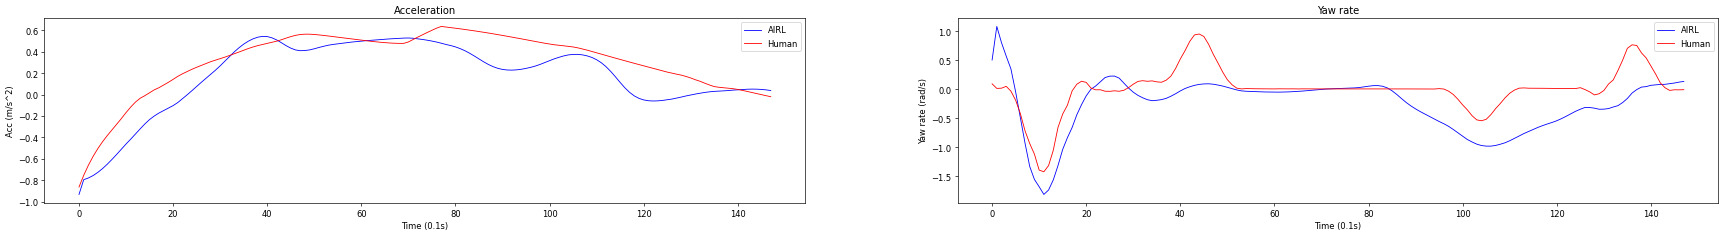

0.14043012261390686


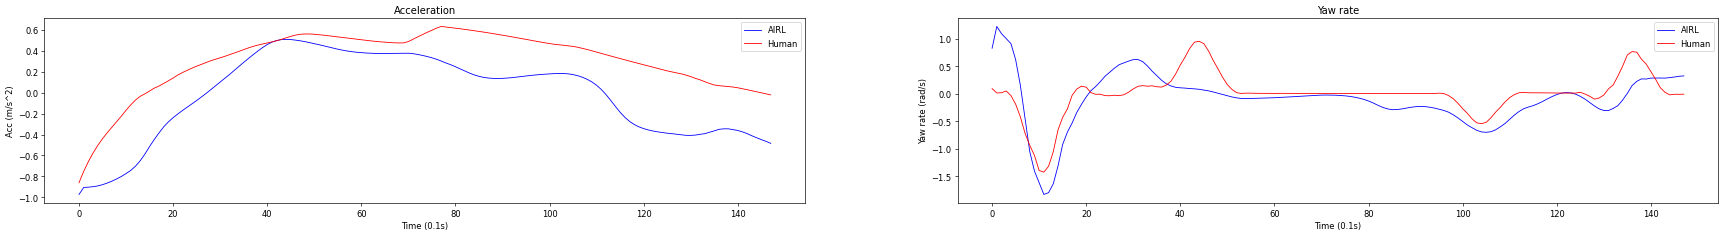

0.22856396436691284


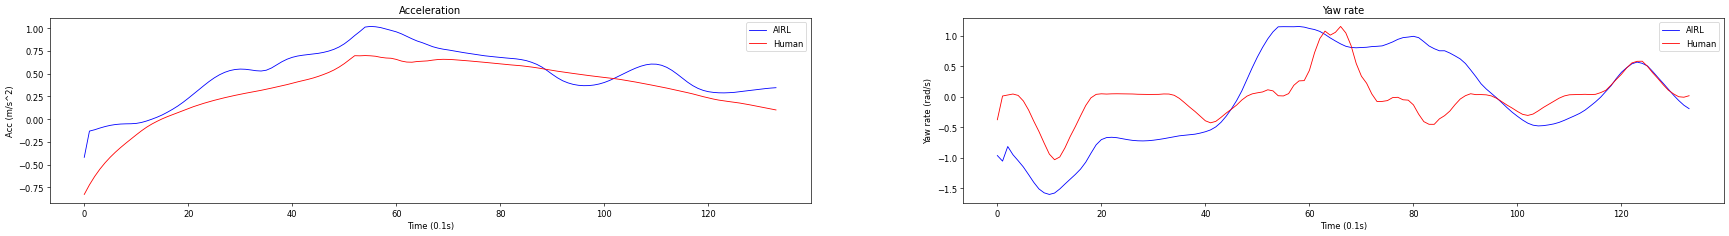

0.08086696267127991


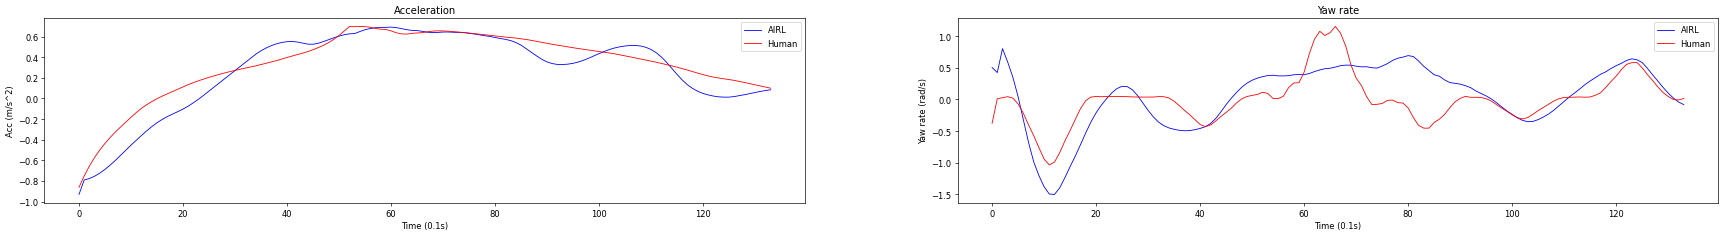

0.13423582911491394


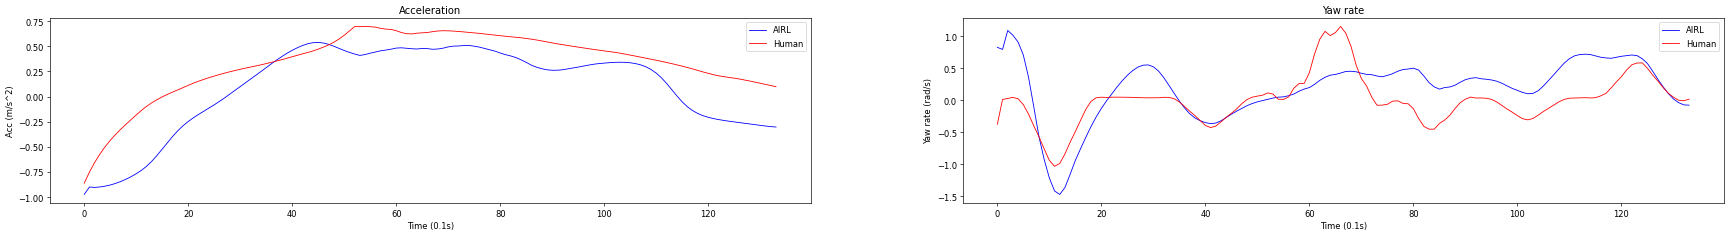

0.252769410610199


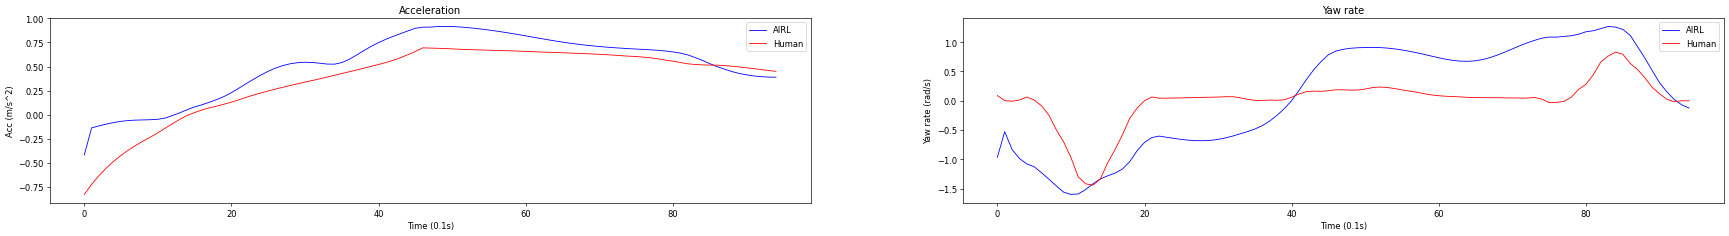

0.08763720095157623


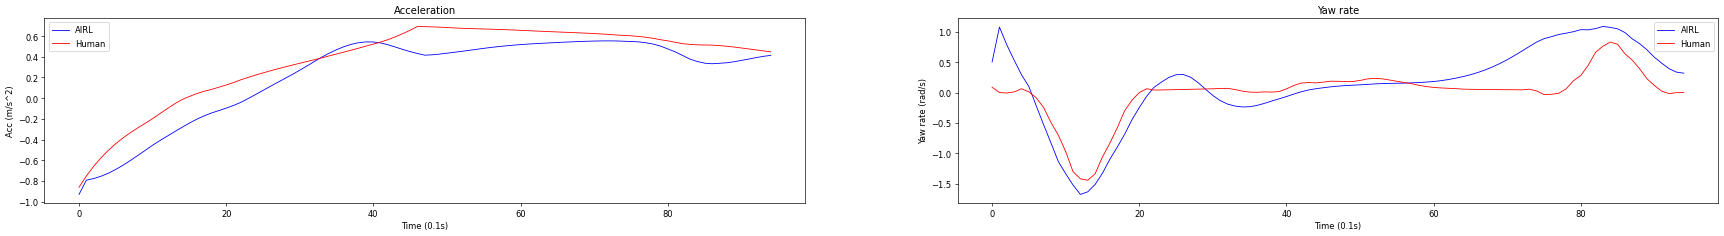

0.15159738063812256


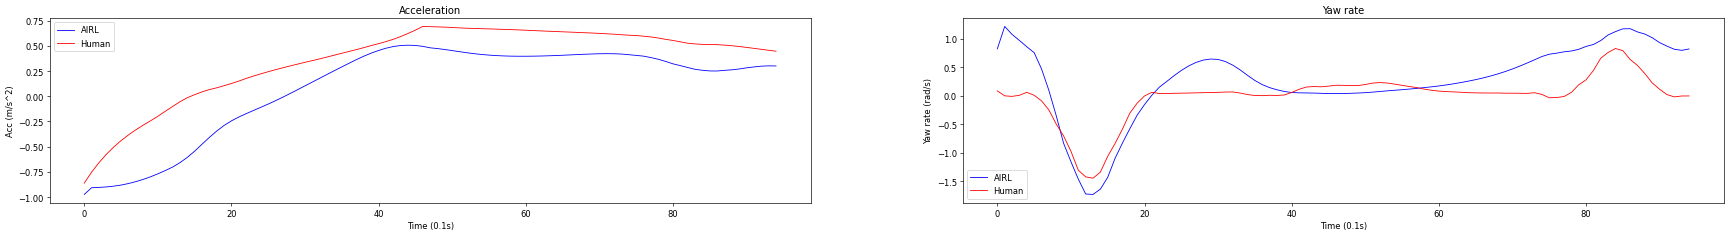

0.1771394908428192


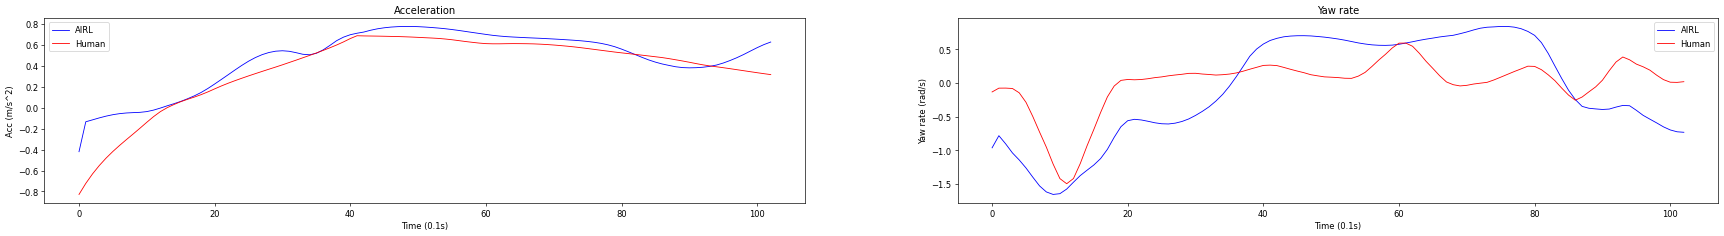

0.06386858969926834


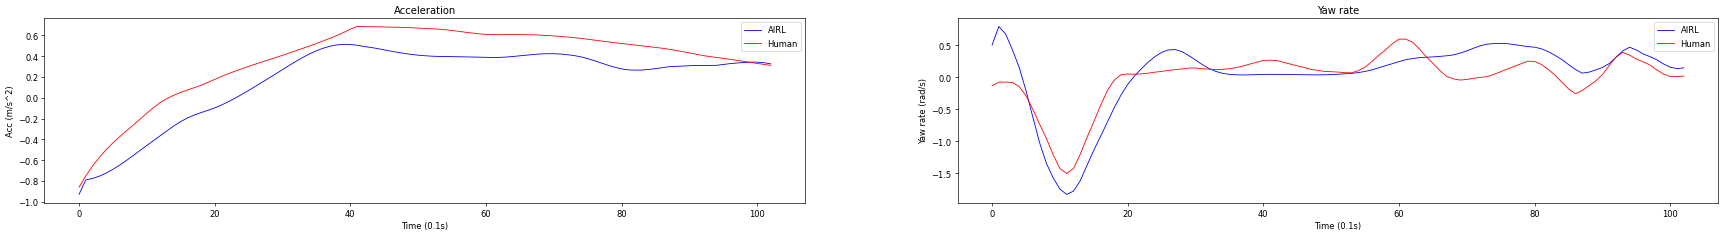

0.1991797834634781


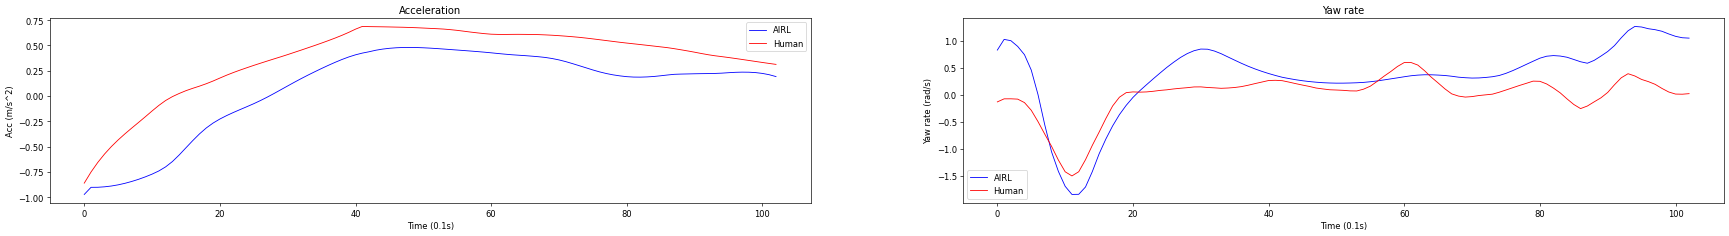

0.20499300956726074


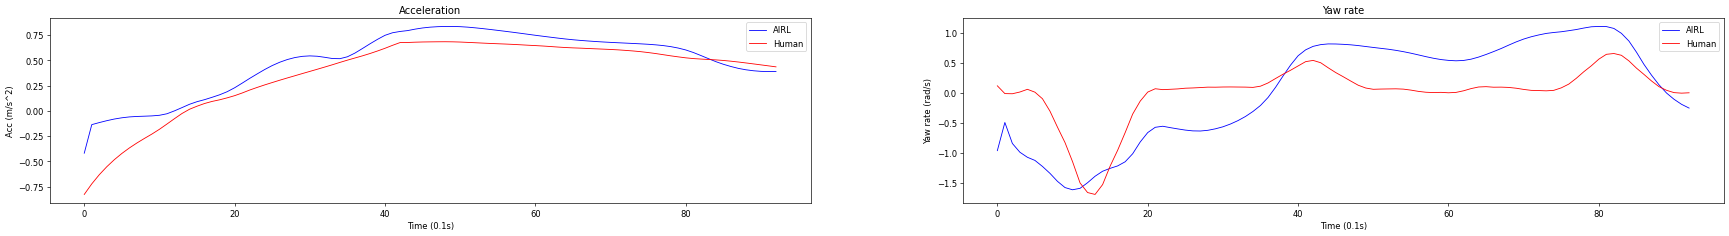

0.07776173949241638


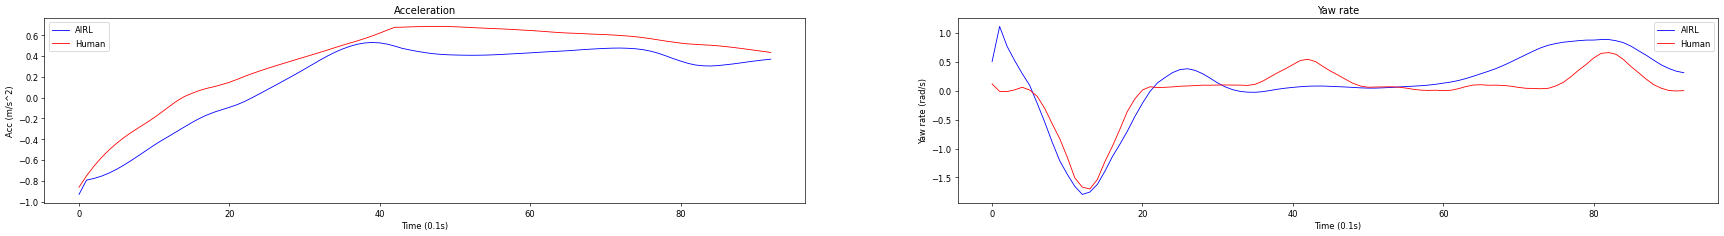

0.16355545818805695


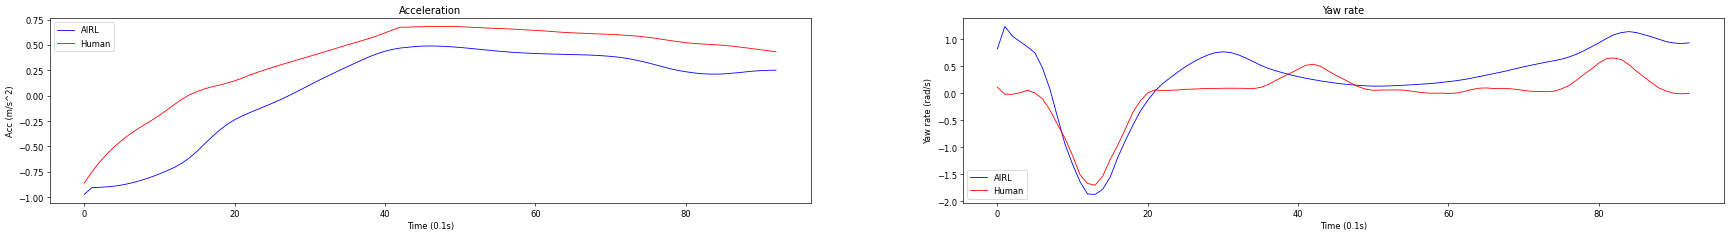

0.3413236439228058


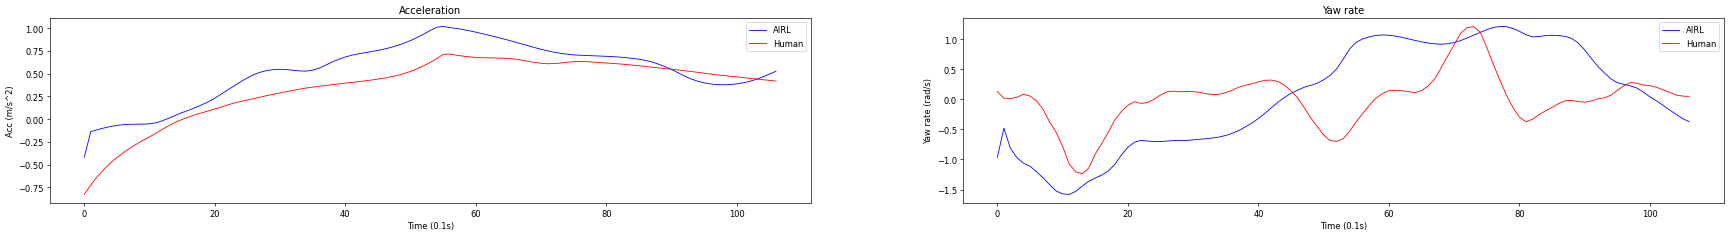

0.12992866337299347


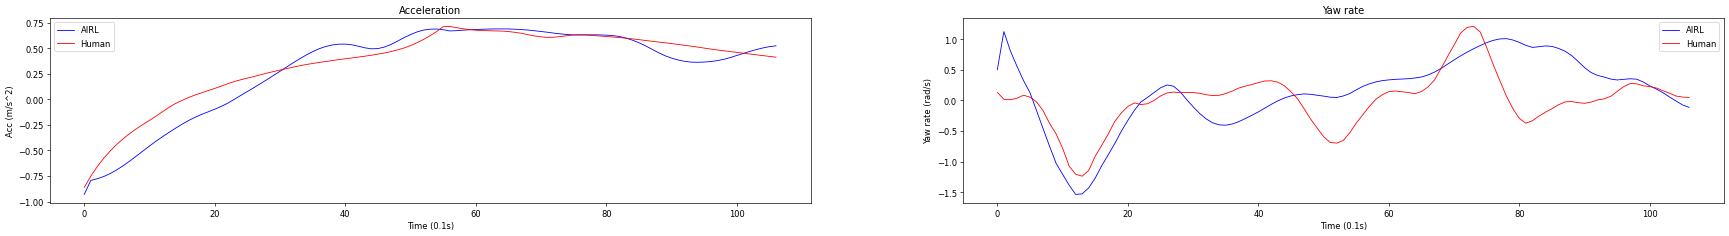

0.14619611203670502


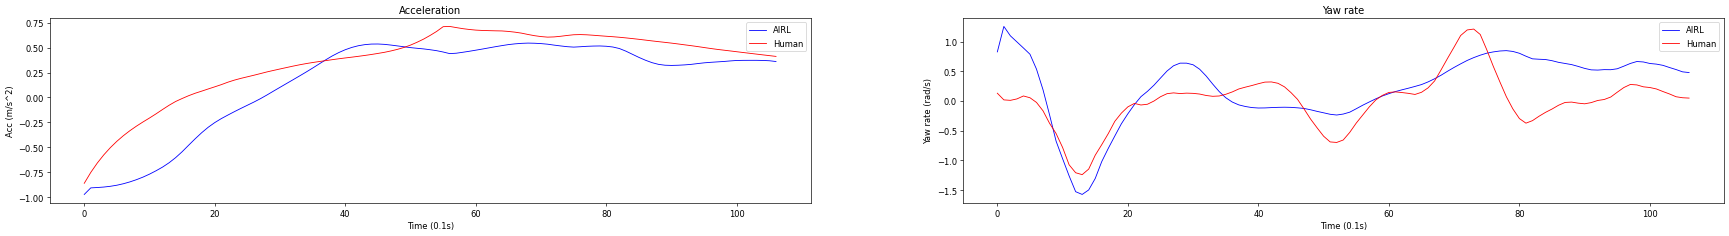

0.35357460379600525


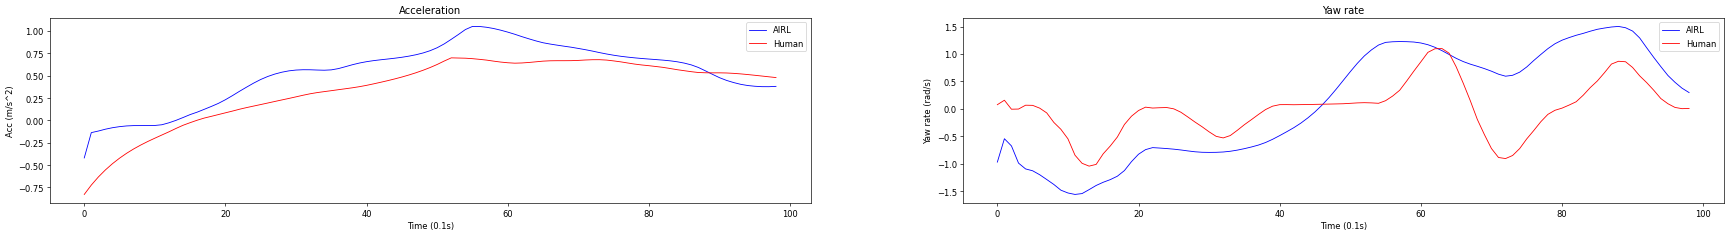

0.13784165680408478


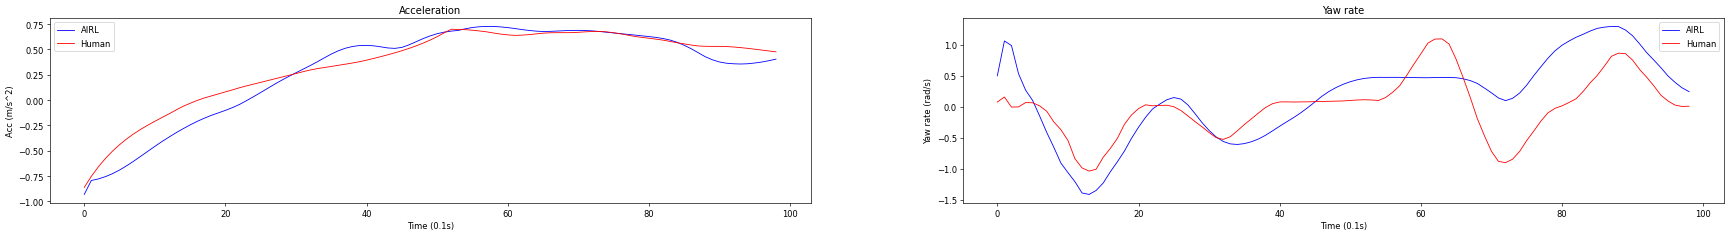

0.16953128576278687


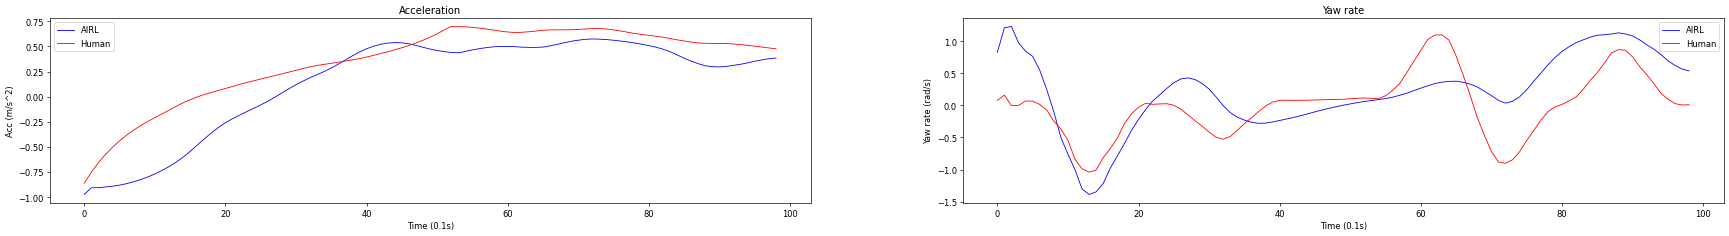

0.17699207365512848


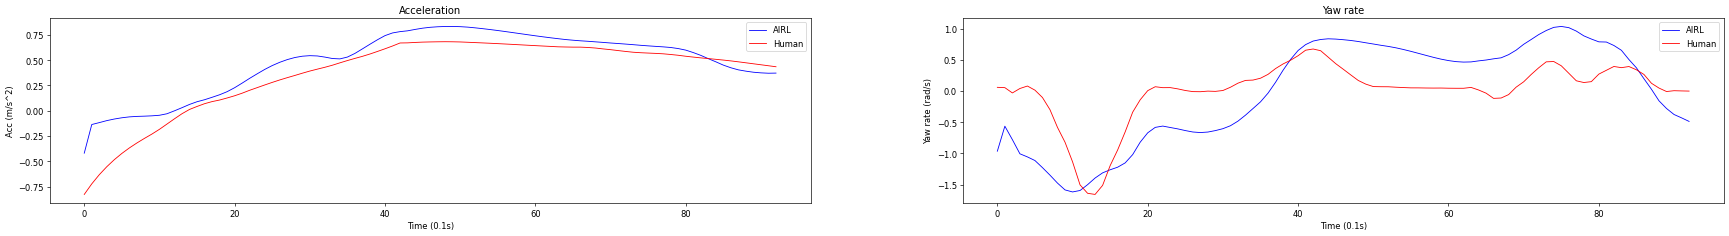

0.06358655542135239


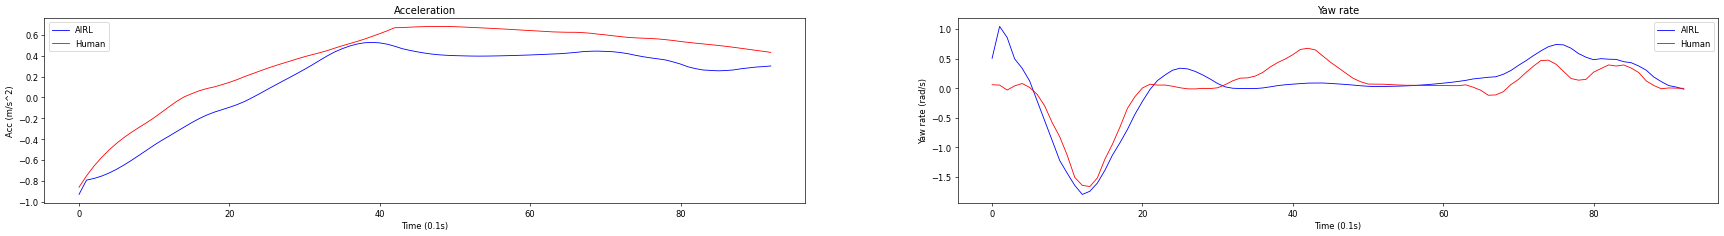

0.1329835206270218


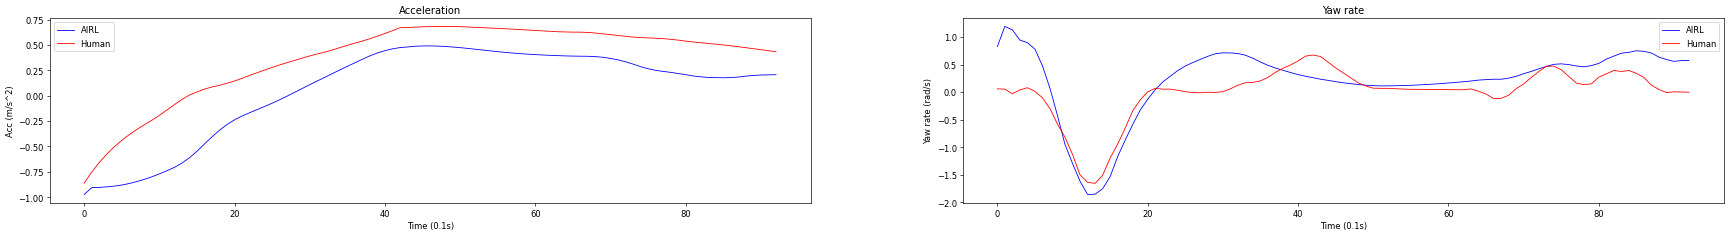

0.2297663688659668


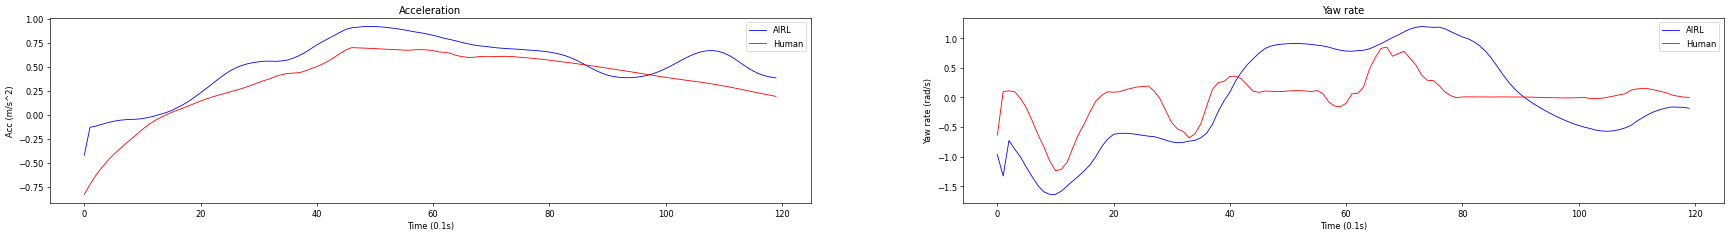

0.08333908021450043


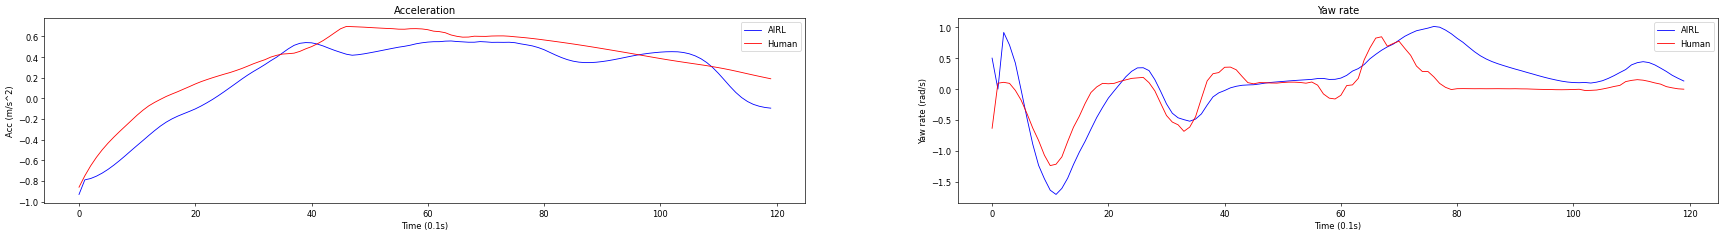

0.20494775474071503


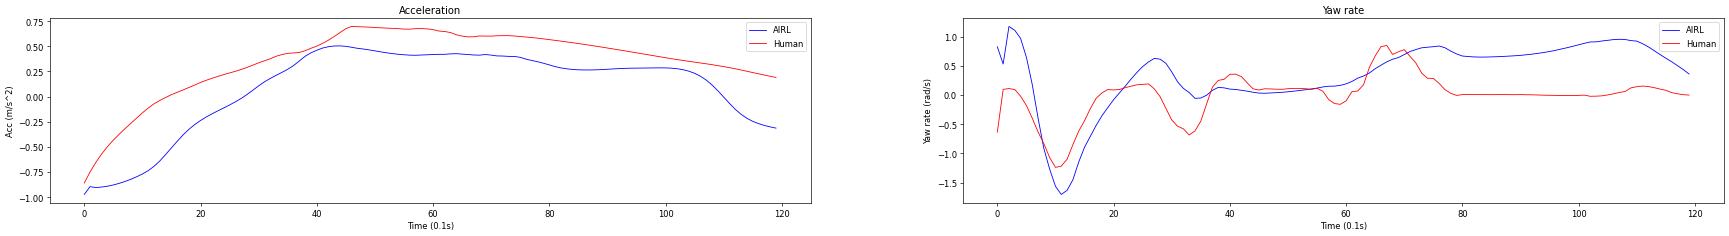

0.16259628666771783

In [25]:
MSE_PATH = []
PATH = "Trained_model/GAIL_"+str(idx[np.argmin(MSE_test)])+".pth"
PATH = 'Trained_model/GAIL_1000.pth'
ppo_agent.load(PATH) 
ppo_agent.set_action_std(0.00000000001) 
ppo_agent.policy_old.eval()

for i in range(0,len(testing_traj)):
    testing_states, testing_actions, _ = torch.split(torch.FloatTensor(testing_traj[i]).to(device), (state_dim,action_dim,state_dim), dim=1)

    actions,_,_ = ppo_agent.policy_old.act(testing_states)
    actions = actions
    mse = loss(actions, testing_actions).item()
    MSE_PATH.append(mse)
    
    # temp1 = loss(actions[:,0], testing_actions[:,0]).item()
    # temp2 = loss(actions[:,1], testing_actions[:,1]).item()
    # print(" ACC      Loss: %1.6f" % (temp1))
    # print(" Yaw rate Loss: %1.6f" % (temp2))

    print(mse)
    Test_plot(actions.cpu(), testing_actions.cpu())
sum(MSE_PATH)/len(MSE_PATH)
